In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray as xr
import rasterio

from tqdm import tqdm
from itertools import zip_longest

from lib.utils import plot_xarray_chip

In [2]:
ds = xr.open_zarr('data/train_zarr').isel(chip_id=slice(None, -100))
ds.lat.load()
ds.lon.load()
ds.datetime.load()
ds.location.load();

In [3]:
ds

,Array,Chunk
Bytes,12.51 GiB,384.00 kiB
Shape,"(5125, 5, 512, 512)","(1, 3, 256, 256)"
Count,82801 Tasks,41000 Chunks
Type,uint16,numpy.ndarray


# Have a look through some example images

/exports/csce/datastore/geos/users/s1205782/Projects/cloudmask/lib/utils.py:44: UserWarning: No contour levels were found within the data range.
  ax.contour(chip.sel(band='cloud_mask'), cmap='gist_gray', vmin=.5, vmax=5, alpha=.3, linewidths=.5)
/exports/csce/datastore/geos/users/s1205782/Projects/cloudmask/lib/utils.py:44: UserWarning: No contour levels were found within the data range.
  ax.contour(chip.sel(band='cloud_mask'), cmap='gist_gray', vmin=.5, vmax=5, alpha=.3, linewidths=.5)
/exports/csce/datastore/geos/users/s1205782/Projects/cloudmask/lib/utils.py:44: UserWarning: No contour levels were found within the data range.
  ax.contour(chip.sel(band='cloud_mask'), cmap='gist_gray', vmin=.5, vmax=5, alpha=.3, linewidths=.5)


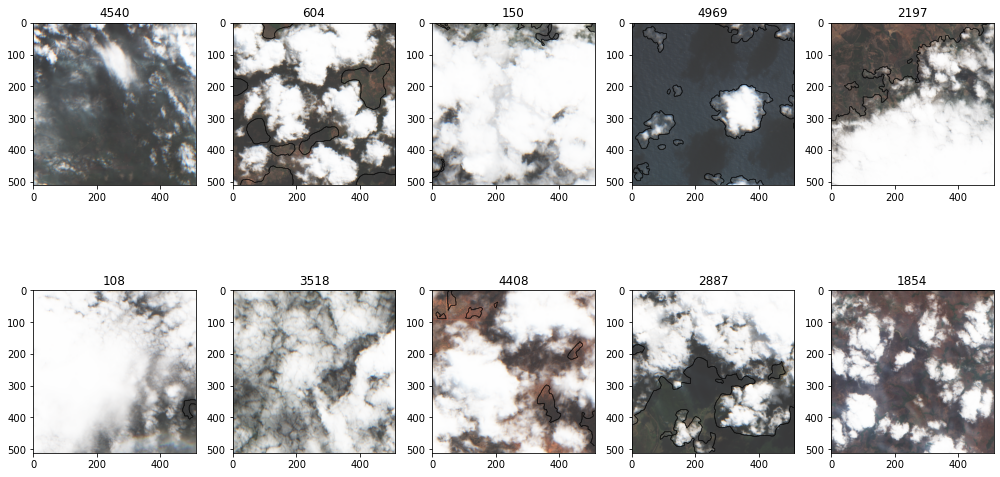

In [9]:
# randomly sample some images
fig, axes = plt.subplots(2,5, figsize=(14, 8))
N = 10
ns = np.random.randint(0, ds.chip_id.shape[0], N)
for n, ax in zip(ns, axes.flatten()):
    plot_xarray_chip(ds.images.isel(chip_id=n), ax=ax)
    ax.set_title(n)
plt.tight_layout()
plt.show()

**Below are the images I've kept as examples**

/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.


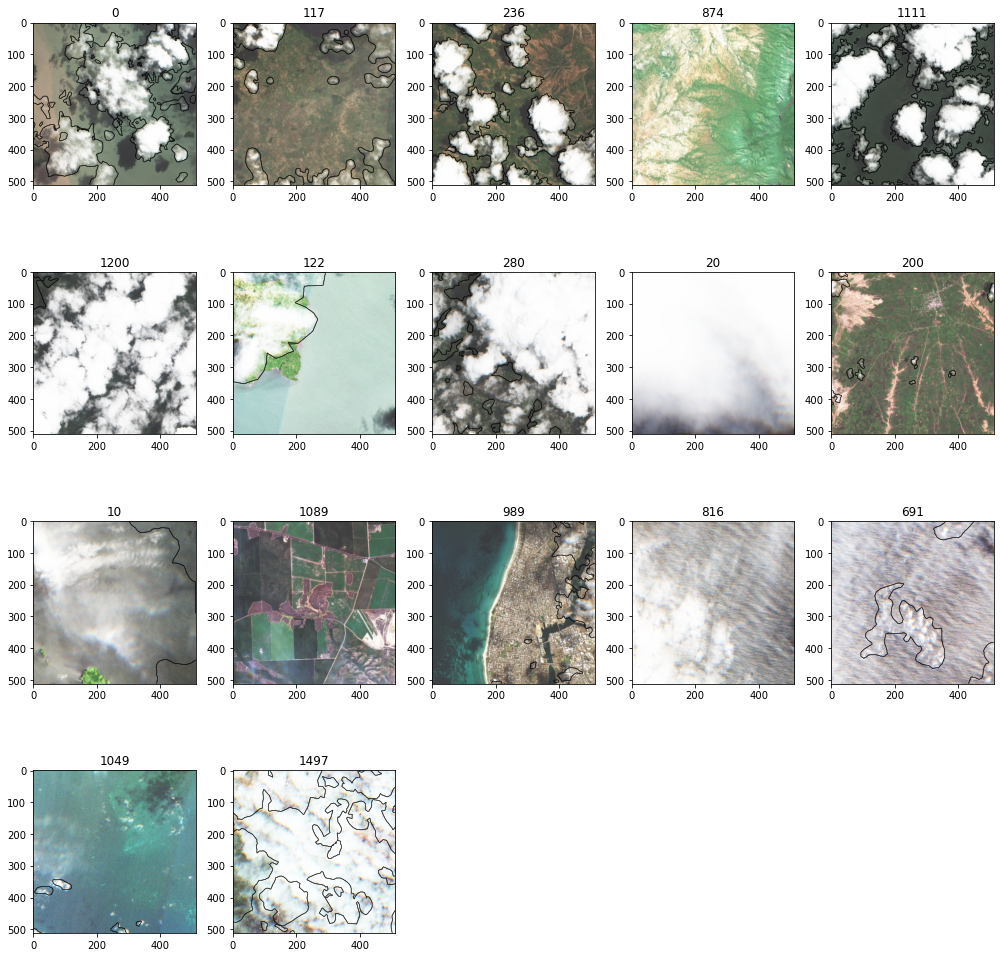

In [105]:
fig, axes = plt.subplots(4,5, figsize=(14,14))
ns = [0, 117, 236, 874, 1111, 1200, 122, 280, 20, 200, 10, 1089, 989, 816, 691, 1049, 1497]
for n, ax in zip_longest(ns, axes.flatten()):
    if n is None:
        ax.axis('off')
    else:
        plot_xarray_chip(ds.images.isel(chip_id=n), ax=ax)
        ax.set_title(n)
plt.tight_layout()
plt.show()

/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: No contour levels were found within the data range.


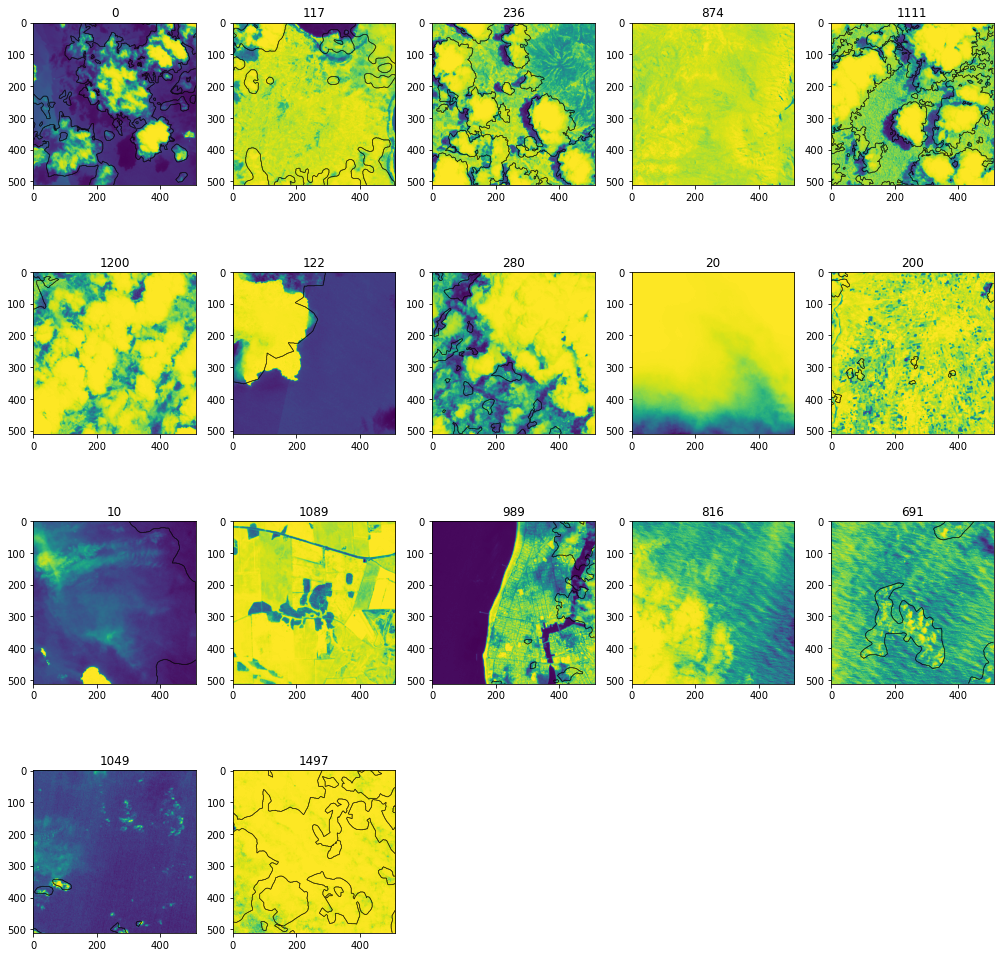

In [106]:
fig, axes = plt.subplots(4,5, figsize=(14,14))
for n, ax in zip_longest(ns, axes.flatten()):
    if n is None:
        ax.axis('off')
    else:
        plot_xarray_chip(ds.images.isel(chip_id=n), ax=ax, infrared_alpha=True)
        ax.set_title(n)
plt.tight_layout()
plt.show()

### Notes
- The masks are really messy
- Largely via False-Positives
- But examples exist (eg cloud on top of cloud) where False-Negatives also exist
- I haven't seen any dark images
- Shadows always fall left of clouds as far as I've seen -> but range 7 o'clock - 11 o'clock from cloud

# Number and positions of sample locations

**Uneven sampling**

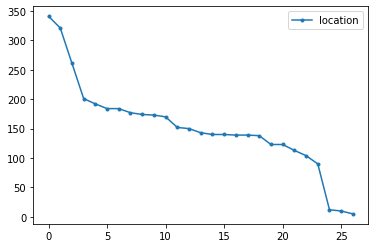

In [233]:
location_count = ds.location.groupby(ds.location).count()
location_count.to_dataframe().reset_index(drop=True).sort_values('location', ascending=False).reset_index(drop=True).plot(marker='.')
plt.show()

In [234]:
location_count.to_dataframe().nlargest(6, 'location')

,location
location,
Chifunfu,341
Chingola,321
South Am,261
Jimma,201
Porto Ve,192
Matadi,184


In [242]:
lats = ds.lat.groupby(ds.location).mean()
lons = ds.lon.groupby(ds.location).mean()
size = (ds.lon.groupby(ds.location).var()+ds.lat.groupby(ds.location).var())**.5 # small scatter on lat-lon of locations

In [243]:
size

<xarray.DataArray (location: 27)>
array([0.38930204, 0.45305718, 0.39350822, 0.42702602, 0.36935492,
       0.38169329, 0.39720389, 0.44443852, 0.40699926, 0.37945073,
       0.39828361, 0.38049073, 0.38652762, 0.39145565, 0.41755496,
       0.38254272, 0.3754796 , 0.41702871, 0.37463476, 0.3882078 ,
       0.38515956, 0.3981388 , 0.39501111, 0.45001201, 0.39857614,
       0.37537028, 0.40822589])
Coordinates:
  * location  (location) object 'Addis Ab' 'Adelaide' ... 'Timbuktu' 'Vitoria'

In [244]:
ds_scat = xr.Dataset({'counts':location_count, 'lat':lats, 'lon':lons, 'size':size})

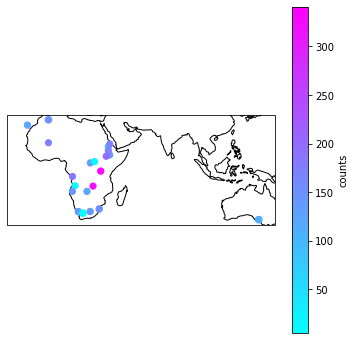

In [245]:
projection = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw=dict(projection=projection))
ax.coastlines()

ds_scat.plot.scatter(x='lon', y='lat', s=ds_scat.size*100, hue='counts', cmap='cool')
plt.xlim(-30, None)
plt.show()

# Data distributions

In [287]:
random_cips = np.random.randint(0, ds.chip_id.shape[0], 100)

In [288]:
def plot_dist(transform=None, ax=None):
    if transform is None:
        transform = lambda x: x
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,6))
    for band in ds.band.values:
        if band=='cloud_mask':
            continue
        else:
            transform(ds.isel(chip_id=random_cips).sel(band=band)).images.plot.hist(bins=100, ax=ax, alpha=.5, label=band)
    ax.set_title('')
    ax.legend()
    return ax

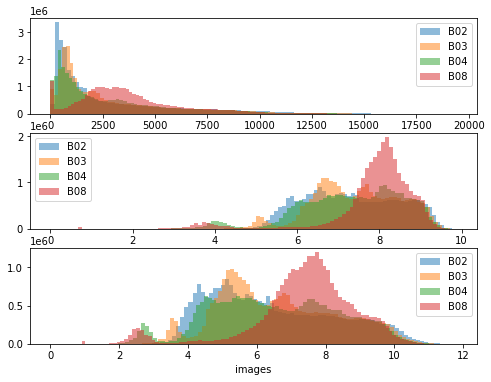

In [289]:
fig, axes = plt.subplots(3,1, figsize=(8,6))

plot_dist(ax=axes[0])
plot_dist(lambda x: np.log(x+1), ax=axes[1])
plot_dist(lambda x: x**.25, ax=axes[2])
plt.show()

**Data is heavily skewed. Some kind of tranform would probably help. Either power law or log.**

In [297]:
random_cips = np.random.randint(0, ds.chip_id.shape[0], 1000)

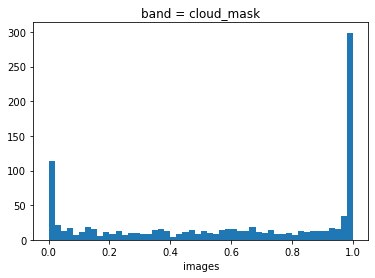

In [299]:
ds.isel(chip_id=random_cips).images.sel(band='cloud_mask').mean(dim=('x', 'y')).plot.hist(bins=50)
plt.show()